In [1]:
#!pip install transformers==4.22.1 -q

In [2]:
import tensorflow as tf

In [3]:
print(tf.__version__)

2.10.0


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [6]:
print(tf.test.is_built_with_cuda())

True


In [7]:
#pip install tensorflow-gpu==2.10

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from collections import Counter
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, GRU, LSTM, Bidirectional, Dense, Dropout,SpatialDropout1D
from tensorflow.keras import regularizers
from keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.pipeline import Pipeline
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

## 

### Importing Data from Azure Blob

In [5]:
import io
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient

In [6]:
connection_string = ""
blob_service_client = BlobServiceClient.from_connection_string(connection_string)

container_client = blob_service_client.get_container_client("database")
blob_client = container_client.get_blob_client("hotel_reviews")
blob_data = blob_client.download_blob().readall()

df = pd.read_csv(io.BytesIO(blob_data))

df.drop(df.columns[0], axis=1, inplace=True)
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [3]:
df = pd.read_csv("C:/Users/meetp/Downloads/!PYTHON FILES/hotel_reviews")

df.drop(df.columns[0], axis=1, inplace=True)
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [10]:
df.shape

(20491, 2)

In [11]:
df.describe()

,Rating
count,20491.000000
mean,3.952223
std,1.233030
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [12]:
df.isnull().sum()

Review    0
Rating    0
dtype: int64

In [13]:
df.duplicated().sum()

0

In [14]:
df['Rating'].unique()

array([4, 2, 3, 5, 1], dtype=int64)

In [15]:
df['Rating'] = df['Rating'] - 1

In [16]:
df['Rating'].unique()

array([3, 1, 2, 4, 0], dtype=int64)

In [17]:
df['Target'] = df['Rating'].apply(lambda x: 0 if x in [0, 1] else (1 if x == 2 else 2))
df['Target'].unique()

array([2, 0, 1], dtype=int64)

## Text Preprocssing

In [18]:
for i in df['Review'][:7]:
    print(i)

nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  
ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike k

In [19]:
# Download stopwords if not already downloaded
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\meetp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
def clean_text(text):
    # Remove non-alphabetic characters (including spaces)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)  
    text = text.lower() 
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words]
    cleaned_text = " ".join(text)
    return cleaned_text

df['Review_Cleaned'] = df['Review'].apply(clean_text)

In [21]:
for i in df['Review_Cleaned'][:10]:
    print(i)

nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous review valet parking check quick easy little disappointed non existent view room room clean nice size bed comfortable woke stiff neck high pillow soundproof like heard music room night morning loud bang door opening closing hear people talking hallway maybe noisy neighbor aveda bath product nice goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience pay parking night
ok nothing special charge diamond member hilton decided chain shot th anniversary seattle start booked suite paid extra website description suite bedroom bathroom standard hotel room took printed reservation desk showed said thing like tv couch ect desk clerk told oh mixed suite description kimpton website sorry free breakfast got kidding embassy suit sitting room bathroom bedroom unlike kimpton call suite day stay offer correct false advertising send 

## 

## EDA

### Rating Count of Distribution

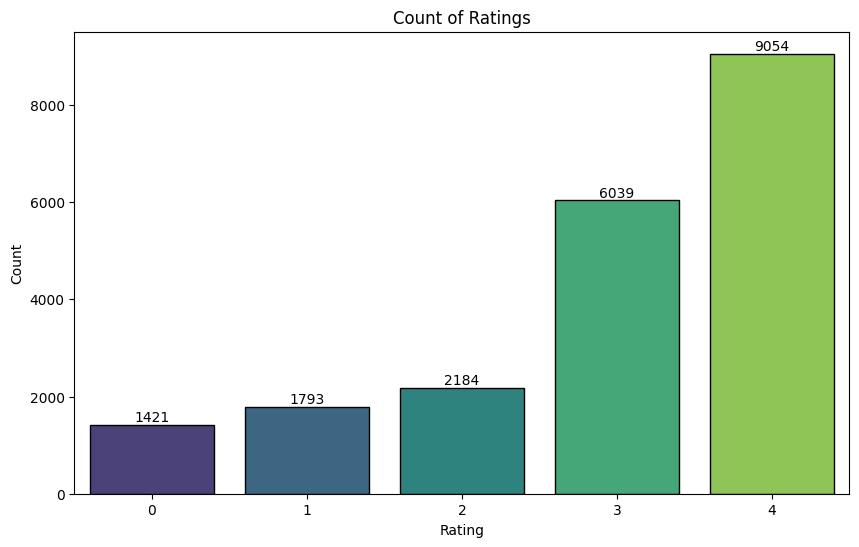

In [22]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='Rating', palette='viridis', edgecolor='black', linewidth=1)

# Add labels to the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 5), 
                textcoords = 'offset points')

plt.title('Count of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

* From above visual, we can say that count of ratings for 4, 5 are comparatively higher than the other rating scores. 
* Hence, we can say from our data that most of the users fairly satisfied but there maybe some areas to improve in experience at hotels

## Rating Percent of Distribution

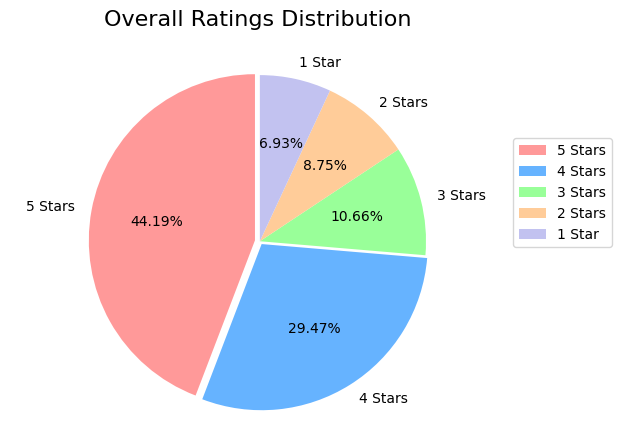

In [23]:
import matplotlib.pyplot as plt

# Data
ratings = df['Rating'].value_counts()
labels = ['5 Stars', '4 Stars', '3 Stars', '2 Stars', '1 Star']
explode = [0.03, 0.02, 0.0, 0.0, 0.0]
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0']  # Custom colors for each category

# Plot
fig, ax = plt.subplots()
ax.pie(ratings, autopct='%0.2f%%', labels=labels, explode=explode, startangle=90, colors=colors)
ax.set_title('Overall Ratings Distribution\n', fontsize=16)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Add legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.8))

# Show plot
plt.show()


* From above visual, we can say that almost 75% of reviews are rated (5, 4) by users and remaining 25% reviews are rated (3, 2, 1).
* We have an unequal distribution of data, where we have some negative ratings provided by users.
* Hence, our dataset is a bit imbalanced

## 

## NLP based Classification

In [25]:
df1 = df.copy()

In [26]:
X = df1[['Review_Cleaned']]
y = df1['Rating']
#y = to_categorical(df1["Rating"])

#y = df1['Target']

In [27]:
y.value_counts()

Rating
4    9054
3    6039
2    2184
1    1793
0    1421
Name: count, dtype: int64

In [28]:
# Tokenize the text data
#tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
#X['Review_tokens'] = X['Review_Cleaned'].apply(lambda x: tokenizer.tokenize(x.lower()))

# Calculate Vocabulary Size
#all_tokens = [token for tokens in X['Review_tokens'] for token in tokens]
#vocab_size = len(set(all_tokens))

# Determine Maximum Length of Sequence
#max_length = max(len(tokens) for tokens in X['Review_tokens'])

# Determine Number of Classes
#num_classes = len(set(y))

#print("Vocabulary Size:", vocab_size)
#print("Maximum Length of Sequence:", max_length)
#print("Number of Classes:", num_classes)

#vocab_size = 44778
#max_length = 1889
#num_classes = 3
#embedding_dim = 100

vocab_size = 44778
max_length = 1889
num_classes = 5
embedding_dim = 100

In [31]:
GRU_tokenizer = Tokenizer(num_words=vocab_size)
GRU_tokenizer.fit_on_texts(X['Review_Cleaned'])
X_sequences = GRU_tokenizer.texts_to_sequences(X['Review_Cleaned'])
X_padded = pad_sequences(X_sequences, maxlen=max_length)

In [32]:
X_padded

array([[   0,    0,    0, ...,  177,  216,    8],
       [   0,    0,    0, ...,  794,    1,  516],
       [   0,    0,    0, ...,   42, 1665,   83],
       ...,
       [   0,    0,    0, ...,  390, 1464,  999],
       [   0,    0,    0, ...,  320, 4658, 3646],
       [   0,    0,    0, ...,  157,  125,   20]])

In [33]:
ros = RandomOverSampler(random_state=0)
X_balanced, y_balanced = ros.fit_resample(X_padded, y)

In [34]:
X_balanced

array([[   0,    0,    0, ...,  177,  216,    8],
       [   0,    0,    0, ...,  794,    1,  516],
       [   0,    0,    0, ...,   42, 1665,   83],
       ...,
       [   0,    0,    0, ...,  149,  217,  391],
       [   0,    0,    0, ...,    3,    1,  149],
       [   0,    0,    0, ...,    1,    3,   13]])

In [35]:
from collections import Counter

# Check the class distribution after resampling
print(Counter(y))
print(Counter(y_balanced))

Counter({4: 9054, 3: 6039, 2: 2184, 1: 1793, 0: 1421})
Counter({3: 9054, 1: 9054, 2: 9054, 4: 9054, 0: 9054})


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify = y_balanced)

In [37]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((36216, 1889), (9054, 1889), (36216,), (9054,))

## 

### GRU 

In [38]:
import random
from keras.layers import LSTM, Bidirectional, GRU

tf.random.set_seed(1)
tf.keras.utils.set_random_seed(1)
gru = Sequential()
gru.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
gru.add(SpatialDropout1D(0.3))
gru.add(GRU(100, dropout=0.3)) 
gru.add(Dropout(0.3))
gru.add(Dense(5, activation='softmax'))
gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1889, 100)         4477800   
                                                                 
 spatial_dropout1d (SpatialD  (None, 1889, 100)        0         
 ropout1D)                                                       
                                                                 
 gru (GRU)                   (None, 100)               60600     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 5)                 505       
                                                                 
Total params: 4,538,905
Trainable params: 4,538,905
Non-trainable params: 0
______________________________________________

In [39]:
optimizer = Adam(learning_rate=0.01)
#optimizer = RMSprop()

gru.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer = optimizer)

In [40]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

gru.fit(X_train, y_train, epochs=2, batch_size=128, validation_data=(X_test, y_test), callbacks = [early_stopping])

Epoch 1/2
283/283 [==============================] - 73s 249ms/step - loss: 0.8633 - accuracy: 0.6328 - val_loss: 0.4666 - val_accuracy: 0.8132
Epoch 2/2
283/283 [==============================] - 70s 248ms/step - loss: 0.3692 - accuracy: 0.8538 - val_loss: 0.3846 - val_accuracy: 0.8474


In [41]:
from tensorflow.keras.models import save_model

#gru.save('GRU_Model.h5')

## 

### Prediction and Evaluation

#### 1) internal random data predictions

In [42]:
X_subset, _, y_subset, _ = train_test_split(X_padded, y, train_size=100, stratify=y)

In [43]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('GRU_Model.h5')

In [44]:
y_pred = np.argmax(loaded_model.predict(X_subset),axis = 1)
y_pred

4/4 [==============================] - 1s 109ms/step


array([1, 2, 3, 0, 1, 4, 3, 4, 4, 1, 1, 4, 3, 4, 4, 4, 0, 1, 2, 1, 4, 2,
       3, 0, 4, 3, 4, 1, 3, 0, 4, 3, 4, 4, 2, 1, 4, 4, 4, 3, 2, 0, 3, 4,
       2, 4, 4, 4, 4, 4, 4, 3, 4, 3, 3, 4, 3, 3, 4, 3, 4, 4, 4, 4, 2, 4,
       4, 2, 3, 4, 2, 2, 4, 4, 4, 4, 3, 4, 1, 3, 3, 4, 0, 2, 3, 4, 4, 4,
       3, 4, 3, 4, 4, 0, 3, 4, 4, 4, 4, 4], dtype=int64)

In [45]:
y_subset.values

array([1, 2, 3, 0, 1, 4, 3, 4, 4, 1, 1, 4, 3, 3, 4, 4, 0, 1, 2, 1, 4, 2,
       3, 0, 4, 3, 4, 1, 3, 0, 4, 3, 4, 4, 2, 1, 4, 4, 4, 4, 2, 0, 3, 3,
       2, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 4, 4, 4, 4, 2, 4,
       4, 2, 3, 4, 2, 2, 4, 4, 4, 4, 3, 4, 1, 3, 3, 4, 0, 2, 3, 4, 3, 4,
       3, 4, 3, 4, 4, 0, 3, 4, 4, 4, 4, 4], dtype=int64)

In [46]:
# Evaluate the model
loss, accuracy = loaded_model.evaluate(X_subset, y_subset)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

4/4 [==============================] - 1s 70ms/step - loss: 0.2228 - accuracy: 0.9200
Test Loss: 0.22275906801223755, Test Accuracy: 0.9200000166893005


In [47]:
print(classification_report(y_subset, y_pred))
print("Classification Report:")

print(confusion_matrix(y_subset, y_pred))
print("Confusion Matrix:")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11
           3       0.96      0.76      0.85        29
           4       0.86      0.98      0.91        44

    accuracy                           0.92       100
   macro avg       0.96      0.95      0.95       100
weighted avg       0.93      0.92      0.92       100

Classification Report:
[[ 7  0  0  0  0]
 [ 0  9  0  0  0]
 [ 0  0 11  0  0]
 [ 0  0  0 22  7]
 [ 0  0  0  1 43]]
Confusion Matrix:


## 

### Custom Ai Generated review predictions

In [62]:
reviews = [
    "This hotel was amazing! Great service and comfortable rooms.",
    "The hotel staff was friendly, but the room was not very clean.",
    "Average hotel. Nothing special, but it served its purpose.",
    "I loved my stay at this hotel. The location was perfect and the staff was helpful.",
    "Best service! The staff went above and beyond to make our stay enjoyable.",
    "Hotel was not worth the price. The amenities were lacking and the room had outdated furniture.",
    "Good hotel overall. Clean rooms and convenient location.",
    "Worst experience at this hotel. The room was dirty and the staff was rude",
    "Terrible experience! The staff was rude and unhelpful. The room smelled bad and was not clean."
]

# Corresponding ratings
ratings = [4, 3, 2, 3, 4, 1, 2, 0, 0]
#ratings2 = [2, 2, 1, 2, 2, 1, 1, 0, 0, 0]

# Create DataFrame
df_review = pd.DataFrame({
    'Review': reviews,
    'Rating': ratings
})


X = df_review['Review']
y = df_review['Rating']

In [63]:
df_review

,Review,Rating
0,This hotel was amazing! Great service and comf...,4
1,"The hotel staff was friendly, but the room was...",3
2,"Average hotel. Nothing special, but it served ...",2
3,I loved my stay at this hotel. The location wa...,3
4,Best service! The staff went above and beyond ...,4
5,Hotel was not worth the price. The amenities w...,1
6,Good hotel overall. Clean rooms and convenient...,2
7,Worst experience at this hotel. The room was d...,0
8,Terrible experience! The staff was rude and un...,0


In [64]:
import random
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

class Preprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.tokenizer = GRU_tokenizer
        
    def clean_text(self, text):
        # Remove non-alphabetic characters (including spaces)
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)  
        text = text.lower() 
        tokens = word_tokenize(text)
        tokens = [self.lemmatizer.lemmatize(word) for word in tokens if word not in self.stop_words]
        cleaned_text = " ".join(tokens)
        return cleaned_text
        
    def fit_transform(self, X):
        X_cleaned = [self.clean_text(text) for text in X]
        X_sequences = self.tokenizer.texts_to_sequences(X_cleaned)
        X_padded = pad_sequences(X_sequences, maxlen=1889, padding='pre')
        return X_padded

In [65]:
preprocess = Preprocessor()

X_padded = preprocess.fit_transform(X)
X_padded

array([[   0,    0,    0, ...,   13,   52,    2],
       [   0,    0,    0, ...,   28,    2,   19],
       [   0,    0,    0, ...,  265,  363, 1843],
       ...,
       [   0,    0,    0, ...,    2,  294,   12],
       [   0,    0,    0, ...,  483,    6,  494],
       [   0,    0,    0, ..., 1123,   96,   19]])

In [176]:
import joblib

joblib.dump(preprocess, "GRU_Preprocessor")

['GRU_Preprocessor']

## 

In [177]:
from tensorflow.keras.models import load_model

# Load the saved model
preprocess = joblib.load("GRU_Preprocessor")
loaded_model = load_model('GRU_Model.h5')

In [67]:
y_pred = np.argmax(loaded_model.predict(X_padded),axis = 1)
y_pred

1/1 [==============================] - 0s 305ms/step


array([4, 3, 2, 4, 4, 1, 3, 0, 0], dtype=int64)

In [68]:
y.values

array([4, 3, 2, 3, 4, 1, 2, 0, 0], dtype=int64)

In [69]:
print(classification_report(y, y_pred))
print("Classification Report:")

print(confusion_matrix(y, y_pred))
print("Confusion Matrix:")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         1
           2       1.00      0.50      0.67         2
           3       0.50      0.50      0.50         2
           4       0.67      1.00      0.80         2

    accuracy                           0.78         9
   macro avg       0.83      0.80      0.79         9
weighted avg       0.81      0.78      0.77         9

Classification Report:
[[2 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 1 0]
 [0 0 0 1 1]
 [0 0 0 0 2]]
Confusion Matrix:


### Testing with Real Reviews from TripAdvisor Website

In [70]:
input = """
The hotel location, staff and food were excellent. We had not expected to stay in Mumbai and hope we will return.
The room was spotless with partial sea view a joy to wake up to each morning.
The staff were extremely helpful and considerate as my husband had been in hospital unexpectedly and we came for him to recuperate - could not have asked for more. They made suggestions for places to see and eat, booked taxis when needed and helped us enjoy Mumbai In difficult circumstances.
Thank you all staff!
"""

input_padded = preprocess.fit_transform([input])
y_pred = np.argmax(loaded_model.predict(input_padded),axis = 1)
y_pred

1/1 [==============================] - 0s 110ms/step


array([4], dtype=int64)

In [83]:
input = """
We stayed here as part of a wedding party and as our first trip to India we were very pleased. The staff from reception to housekeeping and the restaurant were very kind and helpful. We found the nightly dinner buffet to be quite varied and delicious. Breakfast was also a treat. Our room was large and well equipped. Housekeeping kept us fully stocked with bottled water and any thing else we needed
"""

input_padded = preprocess.fit_transform([input])
y_pred = np.argmax(loaded_model.predict(input_padded),axis = 1)
y_pred

1/1 [==============================] - 0s 105ms/step


array([3], dtype=int64)

In [82]:
input = """
It's located centrally, right on Juhu beach. The views from the room are good, but chilling by the pool, especially at sunset is a wonderful experience. The property sits slightly further away from the busy sections of Juhu beach, with direct access to the beach from the pool area. The staff are courteous and helpful. The rooms are just about big enough for 3 persons. The housekeeping staff & concierge staff are friendly and efficient in their work.
"""

input_padded = preprocess.fit_transform([input])
y_pred = np.argmax(loaded_model.predict(input_padded),axis = 1)
y_pred

1/1 [==============================] - 0s 128ms/step


array([2], dtype=int64)

In [78]:
input = """
During my recent stay at the Sea Princess Hotel, I had an extremely unpleasant experience. The rooms were of substandard quality, and on the first night, I encountered several issues, which made my stay feel like a complete nightmare. For instance, I found an insect on the wall, there was no hot water, the sink was clogged, and there were no bath towels. Despite being moved to another room, the issues remained in that room too. Finally, I got to a better room on the third night. When I tried to discuss my concerns with the front desk staff, they showed no consideration or empathy towards the guests. Moreover, there needed to be more communication among the manager and associates, with each providing different prices for services.
However, the food and beverage staff, including Deepak, Imran, Vinnit, Mr. Shaw, and Executive Chef Dev, were excellent. Although the breakfast buffet was small and had limited choices compared to neighbouring hotels, the food and service were great
"""

input_padded = preprocess.fit_transform([input])
y_pred = np.argmax(loaded_model.predict(input_padded),axis = 1)
y_pred

1/1 [==============================] - 0s 112ms/step


array([1], dtype=int64)

In [71]:
input = """
I had checked in , in this third class hotel on 19th October. I was given room no.607. I booked the room for 2 days for which i paid 20,000 rupees and I highly regret for the same. I had a reason to book this hotel—- 1. I wanted a sea facing view which was shown in the pictures. I wanted a peaceful stay with my husband as we were on vacation after a very long time. I wanted to surprise my husband and make it special for him as it was his birthday. I wanted a beautiful experience for my short stay in Mumbai.
BUT NONE OF THESE REQUIREMENTS WERE MET.I was given a very third grade room in 1 corner which had view of residential buildings and their windows ,despite telling the staff that i wanted a sea view and thats the only reason i booked this hotel.The hotel staff was very unprofessional.
In the breakfast buffet, we saw a COCKROACH in the donut tray for which we reported to the staff and the in room dining manager there, they saw and behaved as if it was very normal for them to see a cockroach roaming inside the tray. We asked them to change the trays as it is so unhygienic and the cockroach might have entered other trays as well but the manager denied and said we cannot do that and the same trays were kept there and all other guests were consuming the food items there. I felt very awful after seeing that practice of the staff.. the manager and the staff were not even embarrassed or sorry for the same.
While checking out, i was asked to wait for more than 20 minutes because their cleaning staff couldn’t find a water bottle in the refrigerator which was not there at first place. They wanted to charge me for it, even after telling them that the bottle was not there at the first place.
I felt so humiliated and embarrassed that these people are blaming me for a 20 rupees water bottle wherein i paid 20k for 2 days stays…The staff is absolutely shameless and unprofessional. They don’t know how to behave with the guests and their customer service is extremely poor.
I would say Yuckssssssss for this hotel and the entire experience in this pathetic low class hotel. I will submit this review everywhere possible and make sure that the world gets to know about this hotel and the shameless staff.
"""

input_padded = preprocess.fit_transform([input])
y_pred = np.argmax(loaded_model.predict(input_padded),axis = 1)
y_pred

1/1 [==============================] - 0s 114ms/step


array([0], dtype=int64)

## 

## ML based Classfication

In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [85]:
X = df1['Review_Cleaned']
y = df1['Rating']

In [86]:
RF_vectorizer = TfidfVectorizer()

X = RF_vectorizer.fit_transform(X)
X

<20491x44754 sparse matrix of type '<class 'numpy.float64'>'
	with 1577890 stored elements in Compressed Sparse Row format>

In [87]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_balanced, y_balanced = ros.fit_resample(X, y)

In [88]:
from collections import Counter

# Check the class distribution after resampling
print(Counter(y))
print(Counter(y_balanced))

Counter({4: 9054, 3: 6039, 2: 2184, 1: 1793, 0: 1421})
Counter({3: 9054, 1: 9054, 2: 9054, 4: 9054, 0: 9054})


## 

In [89]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_balanced, y_balanced, test_size=0.33, random_state=42,stratify=y_balanced)

In [90]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30330, 44754), (14940, 44754), (36216,), (9054,))

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [92]:
models = {
    "LogisticRegression": LogisticRegression(),
    "RandomForest": RandomForestClassifier(criterion="entropy"),
    "SVM": SVC(kernel='linear')
}

In [93]:
from sklearn.metrics import accuracy_score

def evaluate_model(X_train,Y_train,X_test,Y_test,models):
    report = {}
    for i in range(len(models)):
        model = list(models.values())[i]
        model.fit(X_train,Y_train)
        Y_test_predict = model.predict(X_test)
        score = accuracy_score(Y_test,Y_test_predict)
        report[list(models.keys())[i]] = score
    
    return report

In [94]:
evaluate_model(X_train,Y_train,X_test,Y_test,models)

{'LogisticRegression': 0.8038152610441767,
 'RandomForest': 0.8920348058902275,
 'SVM': 0.8307898259705488}

## 

## Pipline Building of Preprocessor and Model

In [95]:
#pip install sklearn_pandas

In [96]:
from imblearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer 
from imblearn.pipeline import Pipeline as ImbPipeline

In [97]:
df1.head()

,Review,Rating,Target,Review_Cleaned
0,nice hotel expensive parking got good deal sta...,3,2,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,1,0,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,2,1,nice room experience hotel monaco seattle good...
3,"unique, great stay, wonderful time hotel monac...",4,2,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",4,2,great stay great stay went seahawk game awesom...


In [98]:
X = df1[['Review']]
y = df1['Rating']

In [99]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify = y)

In [100]:
def clean_text(text):
    # Remove non-alphabetic characters (including spaces)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)  
    text = text.lower() 
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words]
    cleaned_text = " ".join(text)
    return cleaned_text

In [101]:
ros = RandomOverSampler(random_state=42)

logistic = LogisticRegression()

RandomForest = RandomForestClassifier(criterion="entropy")

In [102]:
X = df1[['Review']]
y = df1['Rating']

In [103]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify = y)

In [104]:
preprocessor = ImbPipeline([
    ('cleaning', FunctionTransformer(lambda x: x.applymap(clean_text))),
    ('tfidf', ColumnTransformer([
        ('tfidf', RF_vectorizer, 'Review')], remainder='passthrough'))
])

preprocessor

Pipeline(steps=[('cleaning',
                 FunctionTransformer(func=<function <lambda> at 0x0000015C82FF2B80>)),
                ('tfidf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidf', TfidfVectorizer(),
                                                  'Review')]))])

In [105]:
X_test1 = preprocessor.fit_transform(X)
X_test1

<20491x44754 sparse matrix of type '<class 'numpy.float64'>'
	with 1577890 stored elements in Compressed Sparse Row format>

In [106]:
import joblib

joblib.dump(RF_vectorizer, "RF_Vectorizer")

['RF_Vectorizer']

### Model Training

In [107]:
X = df1[['Review']]
y = df1['Rating']

In [108]:
Pipeline = ImbPipeline([
    ('cleaning', FunctionTransformer(lambda x: x.applymap(clean_text))),
    ('tfidf', ColumnTransformer([
        ('tfidf', RF_vectorizer, 'Review')], remainder='passthrough')),
    ('ros', RandomOverSampler(random_state=42)),  
])

In [109]:
X_resampled, y_resampled = Pipeline.fit_resample(X, y)

In [110]:
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=42,stratify = y_resampled)

In [111]:
model1 = RandomForestClassifier(criterion="entropy")

model1.fit(X_train, Y_train)

RandomForestClassifier(criterion='entropy')

In [112]:
Y_test_predict = model1.predict(X_test)

In [113]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Calculate accuracy
accuracy = accuracy_score(Y_test, Y_test_predict)
print("Accuracy:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_test_predict)
print("Confusion Matrix:\n", conf_matrix)

# Generate classification report
class_report = classification_report(Y_test, Y_test_predict)
print("Classification Report:\n", class_report)

Accuracy: 0.8908299866131192
Confusion Matrix:
 [[2982    0    0    0    6]
 [  11 2960    0    4   13]
 [   6    2 2899   42   39]
 [   4   15   25 1932 1012]
 [   9    4    3  436 2536]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      2988
           1       0.99      0.99      0.99      2988
           2       0.99      0.97      0.98      2988
           3       0.80      0.65      0.72      2988
           4       0.70      0.85      0.77      2988

    accuracy                           0.89     14940
   macro avg       0.90      0.89      0.89     14940
weighted avg       0.90      0.89      0.89     14940



In [114]:
import joblib

joblib.dump(model1, "RF_Model")

['RF_Model']

## 

### Custom Ai Generated review predictions

In [143]:
reviews = [
    "This hotel was amazing! Great service and comfortable rooms.",
    "The hotel staff was friendly, but the room was not very clean.",
    "Average hotel. Nothing special, but it served its purpose.",
    "I loved my stay at this hotel. The location was perfect and the staff was helpful.",
    "Best service! The staff went above and beyond to make our stay enjoyable.",
    "Hotel was not worth the price. The amenities were lacking and the room had outdated furniture.",
    "Worst experience at this hotel. The room was dirty and the staff was rude",
    "Terrible experience! The staff was rude and unhelpful. The room smelled bad and was not clean."
]

# Corresponding ratings
ratings = [4, 3, 2, 3, 4, 3, 0, 0]
#ratings2 = [2, 2, 1, 2, 2, 1, 1, 0, 0, 0]

# Create DataFrame
df_review = pd.DataFrame({
    'Review': reviews,
    'Rating': ratings
})


X = df_review['Review']
y = df_review['Rating']

In [144]:
X.head()

0    This hotel was amazing! Great service and comf...
1    The hotel staff was friendly, but the room was...
2    Average hotel. Nothing special, but it served ...
3    I loved my stay at this hotel. The location wa...
4    Best service! The staff went above and beyond ...
Name: Review, dtype: object

In [166]:
import joblib

RF_vectorizer = joblib.load("RF_Vectorizer")
load_model = joblib.load("RF_Model")

In [167]:
X_encoded = RF_vectorizer.transform(X)
X_encoded

<8x44754 sparse matrix of type '<class 'numpy.float64'>'
	with 54 stored elements in Compressed Sparse Row format>

In [168]:
y_pred = load_model.predict(X_encoded)
y_pred

array([4, 3, 2, 4, 4, 4, 0, 0], dtype=int64)

In [169]:
y.values

array([4, 3, 2, 3, 4, 3, 0, 0], dtype=int64)

In [170]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Calculate accuracy
accuracy = accuracy_score(y, y_pred)
print("Accuracy:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Generate classification report
class_report = classification_report(y, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.75
Confusion Matrix:
 [[2 0 0 0]
 [0 1 0 0]
 [0 0 1 2]
 [0 0 0 2]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1
           3       1.00      0.33      0.50         3
           4       0.50      1.00      0.67         2

    accuracy                           0.75         8
   macro avg       0.88      0.83      0.79         8
weighted avg       0.88      0.75      0.73         8



## 

### Testing with Real Reviews from TripAdvisor Website

In [171]:
input = """
The hotel location, staff and food were excellent. We had not expected to stay in Mumbai and hope we will return.
The room was spotless with partial sea view a joy to wake up to each morning.
The staff were extremely helpful and considerate as my husband had been in hospital unexpectedly and we came for him to recuperate - could not have asked for more. They made suggestions for places to see and eat, booked taxis when needed and helped us enjoy Mumbai In difficult circumstances.
Thank you all staff!
"""

input_vectorized = RF_vectorizer.transform([input])
y_pred = load_model.predict(input_vectorized)
y_pred

array([4], dtype=int64)

In [175]:
input = """
I had checked in , in this third class hotel on 19th October. I was given room no.607. I booked the room for 2 days for which i paid 20,000 rupees and I highly regret for the same. I had a reason to book this hotel—- 1. I wanted a sea facing view which was shown in the pictures. I wanted a peaceful stay with my husband as we were on vacation after a very long time. I wanted to surprise my husband and make it special for him as it was his birthday. I wanted a beautiful experience for my short stay in Mumbai.
BUT NONE OF THESE REQUIREMENTS WERE MET.I was given a very third grade room in 1 corner which had view of residential buildings and their windows ,despite telling the staff that i wanted a sea view and thats the only reason i booked this hotel.The hotel staff was very unprofessional.
In the breakfast buffet, we saw a COCKROACH in the donut tray for which we reported to the staff and the in room dining manager there, they saw and behaved as if it was very normal for them to see a cockroach roaming inside the tray. We asked them to change the trays as it is so unhygienic and the cockroach might have entered other trays as well but the manager denied and said we cannot do that and the same trays were kept there and all other guests were consuming the food items there. I felt very awful after seeing that practice of the staff.. the manager and the staff were not even embarrassed or sorry for the same.
While checking out, i was asked to wait for more than 20 minutes because their cleaning staff couldn’t find a water bottle in the refrigerator which was not there at first place. They wanted to charge me for it, even after telling them that the bottle was not there at the first place.
I felt so humiliated and embarrassed that these people are blaming me for a 20 rupees water bottle wherein i paid 20k for 2 days stays…The staff is absolutely shameless and unprofessional. They don’t know how to behave with the guests and their customer service is extremely poor.
I would say Yuckssssssss for this hotel and the entire experience in this pathetic low class hotel. I will submit this review everywhere possible and make sure that the world gets to know about this hotel and the shameless staff.
"""

input_vectorized = RF_vectorizer.transform([input])
y_pred = load_model.predict(input_vectorized)
y_pred

array([0], dtype=int64)